In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

seed = 2023
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
from utils_compare_methods import *
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import vedo
import vedo.dolfin as vdf
from prepare_data import rotate, outside_ball
import pandas as pd

sns.set_theme()
sns.set_context("paper")
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)


Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
nb_data = 1500
save_figs = True

small_data = False
level = 2
data = DataLoader(small_data)
agent = Agent(data, small_data)

if not (os.path.exists(f"./images/")) and save_figs:
    os.makedirs(f"./images/")


file = open("./models/best_model/best_epoch.txt")
for y in file.read().split(" "):
    if y.isdigit():
        best_epoch = int(y)
epochs = [50, 100, 250, 500, 1000, 1500, 2000, best_epoch]
print(len(epochs))
print(epochs)

indices = list(range(0, len(epochs)))
size_per_fig = 4
nb_rows = 2
size_row = int(len(indices) / nb_rows)


max_norm_F : 65.79521
data_size,nb_val,nb_train: 1500 187 1313
data shape: (None, 64, 64, 4)
on val data: residues_interior =  1.4574209e-05
FNO2d model created with hyperparameters : modes:10, width:20, pad_prop:0.05 
8
[50, 100, 250, 500, 1000, 1500, 2000, 1330]


In [3]:
nb_epochs = best_epoch
agent.model.load_weights(f"./models/model_{nb_epochs}/model_weights")


We want to illustrate the fact that the FNO can produce precise and fast results even if the size of given data does not match with size of the data used to train the FNO.

In [4]:
def change_size_fno(param, sizes, Plot=False, nb_epochs=2000):
    solveur_standard = StandardFEMSolver(params=param)
    u_ref, V_ref, dx_ref = solveur_standard.solve_one(0, None, True)

    errors, sols = [], []
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = param[0]

    agent.model.load_weights(f"./models/model_{nb_epochs}/model_weights")

    for size in sizes:
        print(f"{size=}")
        phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, size)
        F = generate_F_numpy(mu0, mu1, sigma, size) / data.max_norm_F
        G = generate_G_numpy(alpha, beta, size)
        X = generate_manual_new_data_numpy(phi, F, G)
        Y = agent.model.call(X)
        predicted_solution = X[:, :, :, 1] * Y[:, :, :, 0] + X[:, :, :, 2]
        predicted_solution = np.reshape(predicted_solution, (size, size))
        predicted_solution_fenics = convert_numpy_matrix_to_fenics(
            predicted_solution, size, 1
        )
        predicted_solution_fenics_proj_V_ex = df.project(
            predicted_solution_fenics,
            V_ref,
            solver_type="gmres",
            preconditioner_type="hypre_amg",
        )
        sols.append(predicted_solution_fenics_proj_V_ex)
        l2_error_fno = (
            df.assemble(
                (((u_ref - predicted_solution_fenics_proj_V_ex)) ** 2) * dx_ref
            )
            ** (0.5)
        ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))
        errors.append(l2_error_fno)

        if Plot:
            plt.figure(figsize=(20, 5.5))
            plt.subplot(1, 4, 1)
            p = df.plot(u_ref, mode="color", cmap=my_cmap)
            plt.colorbar(p)
            plt.title("Reference solution", fontsize="14")
            for i in range(1, 4):
                plt.subplot(1, 4, i + 1)
                p = df.plot(sols[i - 1], mode="color", cmap=my_cmap)
                plt.colorbar(p)
                plt.title(
                    "FNO prediction for nb_vert = "
                    + str(sizes[i - 1])
                    + "\n$L^2$ relative error : "
                    + f"{errors[i-1]}",
                    fontsize="14",
                )

            plt.tight_layout()
            if Plot and save_figs:
                plt.savefig(f"./images/change_sizes.png")
            plt.show()

    return errors


In [5]:
errors = []
nb_params_to_test = 100
F, phi, G, params = new_create_FG_numpy(nb_params_to_test, 64)
sizes = [48, 64, 84, 100, 120, 140]
print(len(sizes))
print(f"{len(sizes)=}")
for i in range(np.shape(params)[0]):
    print(f"Param : {i+1}/{np.shape(params)[0]}")
    error = change_size_fno(
        np.array([params[i]]), sizes, Plot=False, nb_epochs=best_epoch
    )
    errors.append(error)
errors = np.array(errors)


6
len(sizes)=6
Param : 1/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.39319298  0.72682552  0.17974054  0.39034756  0.4871882   0.28601861
  0.32884805  0.43410995 -0.62655892  0.68055809]
Solving linear variational problem.
size=48
size=64
size=84
size=100
size=120
size=140
Param : 2/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.73425347  0.51143837  0.21025697  0.52670825  0.44398343  0.39569229
  0.3739559   0.19894767  0.45950746 -0.13600575]
Solving linear variational problem.
size=48
size=64
size=84
size=100
size=120
size=140
Param : 3/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [0.55283135 0.60829806 0.25219354 0.51161827 0.39912867 0.20417092
 0.27739458 0.27917944 0.5122684  0.40841907]
Solving linear variational problem.
size=48
size=64
size=84
size=100
size=120
size=140
Param : 4/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.27595766  0.46133483  0.18224217  0.35280571  0.47150246  0.2344631
  0.3

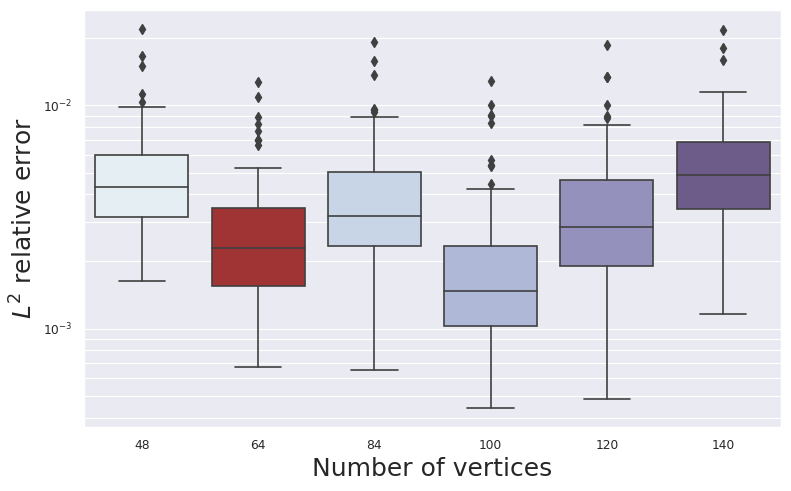

In [14]:
abs_str = sizes
dataframe = pd.DataFrame(errors, columns=abs_str)
palette = sns.cubehelix_palette(
    n_colors=len(sizes) - 1, start=0.25, rot=-0.25, gamma=0.5
)
palette = palette.as_hex()
palette.insert(sizes.index(64), "#b22222")
palette = sns.color_palette(palette)

plt.figure(figsize=(8, 5))

sns.boxplot(data=dataframe, palette=palette)
plt.yscale("log")
plt.grid(True, which="both", axis="y")
plt.xlabel("Number of vertices", fontsize=18)
plt.ylabel("$L^2$ relative error", fontsize=18)
plt.minorticks_on()
plt.tight_layout()

if save_figs:
    plt.savefig(f"./images/boxplots_new_data_change_size.png")
plt.show()

In [15]:
domains = []
solutions = []
for size in sizes:
    i = 0
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = (
        0.30122539,
        0.29640635,
        0.25481616,
        0.46192393,
        0.48159562,
        0.37990447,
        0.32648597,
        0.41180092,
        0.37976006,
        -0.31339751,
    )
    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, size)
    F = generate_F_numpy(mu0, mu1, sigma, size) / data.max_norm_F
    G = generate_G_numpy(alpha, beta, size)
    X = generate_manual_new_data_numpy(phi, F, G)
    Y = agent.model.call(X)
    predicted_solution = X[0, :, :, 1] * Y[0, :, :, 0] + X[0, :, :, 2]
    solutions.append(predicted_solution)
    domains.append(X[:, :, :, -1])

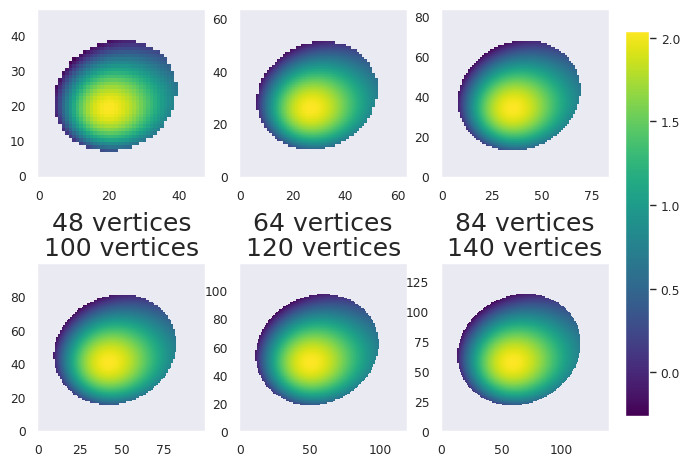

In [16]:
fig, axes = plt.subplots(figsize=(8, 5.5), nrows=2, ncols=3)
i = 0
for ax in axes.flat:
    domains_nan = domains[i].numpy()
    domains_nan[domains_nan == 0] = np.nan
    im = ax.imshow(
        (domains_nan * solutions[i])[0, :, :], cmap="viridis", origin="lower"
    )
    if i >= 3:
        ax.set_title(f"{sizes[i]} vertices", fontsize=18)
    else:
        ax.set_title(f"{sizes[i]} vertices", fontsize=18, y=-0.2, pad=-14)
    ax.grid(False)

    i += 1
fig.subplots_adjust(right=0.84, hspace=0.5)
cbar_ax = fig.add_axes([0.86, 0.14, 0.030, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig(f"./images/outputs_various_sizes.png")
plt.show()
